<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Documentation" data-toc-modified-id="Documentation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Documentation</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Initial-Data-Quality-Assessment-&amp;-Configuration" data-toc-modified-id="Initial-Data-Quality-Assessment-&amp;-Configuration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initial Data Quality Assessment &amp; Configuration</a></span><ul class="toc-item"><li><span><a href="#Read-in-the-Dataframe" data-toc-modified-id="Read-in-the-Dataframe-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Read-in the Dataframe</a></span></li><li><span><a href="#Inspect-Memory-Usage-and-Dtypes" data-toc-modified-id="Inspect-Memory-Usage-and-Dtypes-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Inspect Memory Usage and Dtypes</a></span></li><li><span><a href="#Save-a-serialised-version-of-dataframe-w/-correct-dtypes" data-toc-modified-id="Save-a-serialised-version-of-dataframe-w/-correct-dtypes-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Save a serialised version of dataframe w/ correct dtypes</a></span><ul class="toc-item"><li><span><a href="#Assess-Dataframe" data-toc-modified-id="Assess-Dataframe-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Assess Dataframe</a></span></li><li><span><a href="#Correct-Oversight:-Type-Conversion" data-toc-modified-id="Correct-Oversight:-Type-Conversion-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Correct Oversight: Type Conversion</a></span></li><li><span><a href="#Correct-Oversight:-LASTUPDATE-UNNEEDED" data-toc-modified-id="Correct-Oversight:-LASTUPDATE-UNNEEDED-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Correct Oversight: LASTUPDATE UNNEEDED</a></span></li></ul></li></ul></li><li><span><a href="#Inquiries-:-Data-Quality-assurance" data-toc-modified-id="Inquiries-:-Data-Quality-assurance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Inquiries : Data Quality assurance</a></span><ul class="toc-item"><li><span><a href="#Examine-Planned-/-Actual-times-of-Arrival-/-Departure" data-toc-modified-id="Examine-Planned-/-Actual-times-of-Arrival-/-Departure-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Examine Planned / Actual times of Arrival / Departure</a></span><ul class="toc-item"><li><span><a href="#Nature-of-the-values" data-toc-modified-id="Nature-of-the-values-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Nature of the values</a></span></li><li><span><a href="#Examining:-More-Actual-Times-than-Predicted-Times" data-toc-modified-id="Examining:-More-Actual-Times-than-Predicted-Times-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Examining: More Actual Times than Predicted Times</a></span></li></ul></li></ul></li><li><span><a href="#READ-IN-FEATHER" data-toc-modified-id="READ-IN-FEATHER-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>READ-IN FEATHER</a></span></li></ul></div>

# Documentation

- Each record of this table contains the actual data for one leave time of one vehicle at one stop
point of the route.

<br>

- If the leave time is planned and achieved, the record will contain both the planned and actual data.

<br>

- If the leave time is planned and suppressed, the record will contain only the planned data and the flag “Suppressed” will be checked.

<br>

- Each record could be referred to a fault event by using the field “JustificationID”.

- According with the time representation defined for planned data, AVL data refer to one day of service that could be greater than 24 hours. 

<br>

- For example a trip starting at 23:30 of 1st of April and ending at 00:30 of the 2nd of April could have the last AVL data tracked at “24:30 of 1st of April”. 

<br>

- To express this “extended time” the interface requires the use of seconds past the beginning of the operation day.

<br>

- In our example the DayOfService is “01/04/2014” and the extended time is “88200” (= 24 * 60 * 60 + 30 * 60).

---

- the distance is expressed in the unit of measurement according with the DMS settings. It could be “kilometers” or “miles”.

<br>

- Each table contains a field called “LastUpdate” used to detect new data availability.

| Column | Desc. |
| --- | --- |
| DayOfService | One day of service could last more than 24hrs |
| TripID | Unique Trip Code |
| ProgrNumber | Sequential position of the stop point in the trip |
| StopPointID | Unique stop point code |
| PlannedTime_Arr | Planned arrival time at the stop point, in seconds |
| PlannedTime_Dept | Planned departure time from the stop point, in seconds |
| ActualTime_Arr | Actual arrival time at the stop point, in seconds |
| ActualTime_Dept | Actual departure time from the stop point, in seconds |
| VehicleID | Unique vehicle code arriving a this stop point |
| LastUpdate | Time of the last record update |


NB — — — — The 'stoppointid' attribute is the bus stop id which can be linked to actual bus stops using the open data in the Dublin Bus GTFS file.

# Imports

In [3]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:90% !important;}</style>'))

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Display plots in the notebook
%matplotlib inline

In [5]:
def assess_df(df):
  
    feature_types = {df[df.columns[x]].dtypes.name for x in range(len(df.columns))}
    
  	# print datatypes
  
    print("Datatypes:\n")
    print(df.dtypes)
    print('\n\n')
    
    # print number rows and cols
    print('*' * 50)
    print('ROWS, COLUMNS, NULLS\n')
    print(df.shape[0], "rows in the dataframe.")
    print(df.shape[1], "columns in the dataframe.\n")
    print(df.isnull().sum().sum(), "null values in the dataframe.")
    
    # check duplicate rows & col; print if present
    
    duplicate_rows = df.duplicated(keep=False).sum()
    duplicate_cols = df.index.T.duplicated(keep=False).sum()
    
    print(duplicate_rows, "duplicate rows")
    print(duplicate_cols, "duplicate columns")
    
    if duplicate_rows > 0 or duplicate_cols > 0:
      print(df.loc[df.duplicated()])
	
    print('\n')
    
    # check for constant columns
    
    numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
    categorical_cols = list(df.select_dtypes('category').columns.values)
    
    standard_diffs = [df.describe().loc['std', x] for x in numeric_cols]
    
    constant_categorical_column=False
    if 'category' in feature_types:
        for column in categorical_cols:
            if df[column].describe().index.unique == 1:
                constant_categorical_column = True
            
            
    if 0 in standard_diffs:
        print("Constant numeric columns: TRUE")
    else:
        print("Constant numeric columns: FALSE")
  
    if 'category' in feature_types:    
        if constant_categorical_column == True:
            print("Constant categorical columns: TRUE")
        else:
            print("Constant categorical columns: FALSE")

            
    
    print('\n\n')

    
    # feature stats
    print('*' * 50)
    print('DESCRIPTION\n')
    print(df.describe().T)
    print('\n\n')
    print('*' * 50)

    
    # feature stats: categorical
    
    if 'category' in feature_types:
        print('CATEGORICAL DESCRIPTION\n')
        print('\n')
        print(df.select_dtypes(['category']).describe().T)
        print('\n\n')
        print('*' * 50)
    
    # print feature cardinalities
    
    print("FEATURE CARDINALITIES\n")
    column_names = list(df.columns.values)

    print('{0:45}  {1}'.format("Feature", "Distinct Values"))
    print('{0:45}  {1}'.format("-------", "--------------- \n"))

    for c in column_names:
        print('{0:45}  {1}'.format(c, str(len(df[c].unique()))))
    
    print('\n')
    print('*' * 50)
    print('MEMORY\n')
    
    
    print(df.info(memory_usage='deep'))
    print('\n')
    print(df.memory_usage(deep=True))
    print('\n')
    print('*' * 50)
    print('HEAD\n')
    print(df.head(10))
    print('\n')
    print('*' * 50)
    print('TAIL\n')
    print(df.tail(10))

# Initial Data Quality Assessment & Configuration

## Read-in the Dataframe

In [6]:
path = \
'/tmp/ssh_mount/rt_leavetimes_DB_2018.txt'

dtypes={
    'TRIPID':'category',
    'PROGRNUMBER':'category',
    'STOPPOINTID':'int32',
    'PLANNEDTIME_ARR':'int32',
    'PLANNEDTIME_DEP':'int32',
    'ACTUALTIME_ARR':'int32',
    'ACTUALTIME_DEP':'int32',
    'VEHICLEID':'category'
}

chunks = pd.read_csv(path, chunksize=1000000, sep=';', parse_dates=['DAYOFSERVICE','LASTUPDATE'])

In [7]:
df = pd.concat(chunks)

## Inspect Memory Usage and Dtypes

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116949113 entries, 0 to 116949112
Data columns (total 10 columns):
DAYOFSERVICE       datetime64[ns]
TRIPID             int64
PROGRNUMBER        int64
STOPPOINTID        int64
PLANNEDTIME_ARR    int64
PLANNEDTIME_DEP    int64
ACTUALTIME_ARR     int64
ACTUALTIME_DEP     int64
VEHICLEID          int64
LASTUPDATE         datetime64[ns]
dtypes: datetime64[ns](2), int64(8)
memory usage: 8.7 GB


Reading in as specified dtypes failed. Convert now.

In [12]:
df = df.astype({
    'TRIPID':'category',
    'PROGRNUMBER':'category',
    'STOPPOINTID':'category',
    'PLANNEDTIME_ARR':'int32',
    'PLANNEDTIME_DEP':'int32',
    'ACTUALTIME_ARR':'int32',
    'ACTUALTIME_DEP':'int32',
    'VEHICLEID':'category'
})

Check Memory Usage

In [13]:
# check the true memory usage of the dataframe as a whole

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116949113 entries, 0 to 116949112
Data columns (total 10 columns):
DAYOFSERVICE       datetime64[ns]
TRIPID             category
PROGRNUMBER        category
STOPPOINTID        int32
PLANNEDTIME_ARR    int32
PLANNEDTIME_DEP    int32
ACTUALTIME_ARR     int32
ACTUALTIME_DEP     int32
VEHICLEID          category
LASTUPDATE         datetime64[ns]
dtypes: category(3), datetime64[ns](2), int32(5)
memory usage: 4.7 GB


In [14]:
# check the memory usage of each column

df.memory_usage(deep=True)

Index                     80
DAYOFSERVICE       935592904
TRIPID             494039660
PROGRNUMBER        116955105
STOPPOINTID        467796452
PLANNEDTIME_ARR    467796452
PLANNEDTIME_DEP    467796452
ACTUALTIME_ARR     467796452
ACTUALTIME_DEP     467796452
VEHICLEID          233948394
LASTUPDATE         935592904
dtype: int64

In [16]:
# total bites is 4.7GB in bytes
# print the proportion of memory used by one of the two datetime columns

total_bytes = 4939212390
print(round(935592904/total_bytes, 2), "% of memory used by LASTUPDATE",)

0.19 % of memory used by LASTUPDATE


## Save a serialised version of dataframe w/ correct dtypes

### Assess Dataframe

In [108]:
df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,LASTUPDATE
0,2018-01-01,5972116,12,119,48030,48030,48012,48012,2693211,2018-01-08 17:21:10
1,2018-01-01,5966674,12,119,54001,54001,54023,54023,2693267,2018-01-08 17:21:10
2,2018-01-01,5959105,12,119,60001,60001,59955,59955,2693263,2018-01-08 17:21:10
3,2018-01-01,5966888,12,119,58801,58801,58771,58771,2693284,2018-01-08 17:21:10
4,2018-01-01,5965960,12,119,56401,56401,56309,56323,2693209,2018-01-08 17:21:10


In [24]:
assess_df(df)

Datatypes:

DAYOFSERVICE       datetime64[ns]
TRIPID                   category
PROGRNUMBER              category
STOPPOINTID                 int32
PLANNEDTIME_ARR             int32
PLANNEDTIME_DEP             int32
ACTUALTIME_ARR              int32
ACTUALTIME_DEP              int32
VEHICLEID                category
LASTUPDATE         datetime64[ns]
dtype: object



**************************************************
ROWS, COLUMNS, NULLS

116949113 rows in the dataframe.
10 columns in the dataframe.

0 null values in the dataframe.
0 duplicate rows
0 duplicate columns


Constant numeric columns: FALSE
Constant categorical columns: FALSE



**************************************************
DESCRIPTION

                       count          mean           std      min      25%  \
STOPPOINTID      116949113.0   2500.256284   2016.848273      2.0    925.0   
PLANNEDTIME_ARR  116949113.0  53263.483617  17496.620711  16200.0  37975.0   
PLANNEDTIME_DEP  116949113.0  53263.483617  17496.62071

### Correct Oversight: Type Conversion

In [30]:
# this as a categorical feature overlooked. rectifying.

df.STOPPOINTID = df.STOPPOINTID.astype('category')

### Correct Oversight: LASTUPDATE UNNEEDED

In [112]:
df.drop('LASTUPDATE', axis=1, inplace=True)

In [113]:
assess_df(df)

Datatypes:

DAYOFSERVICE       datetime64[ns]
TRIPID                   category
PROGRNUMBER              category
STOPPOINTID              category
PLANNEDTIME_ARR             int32
PLANNEDTIME_DEP             int32
ACTUALTIME_ARR              int32
ACTUALTIME_DEP              int32
VEHICLEID                category
dtype: object



**************************************************
ROWS, COLUMNS, NULLS

116949113 rows in the dataframe.
9 columns in the dataframe.

0 null values in the dataframe.
0 duplicate rows
0 duplicate columns


Constant numeric columns: FALSE
Constant categorical columns: FALSE



**************************************************
DESCRIPTION

                       count          mean           std      min      25%  \
PLANNEDTIME_ARR  116949113.0  53263.483617  17496.620711  16200.0  37975.0   
PLANNEDTIME_DEP  116949113.0  53263.483617  17496.620711  16200.0  37975.0   
ACTUALTIME_ARR   116949113.0  53446.370011  17507.103983  15974.0  38105.0   
ACTUALTIME_D

In [114]:
df.to_feather("leavetimes_trimmed.feather")

# Inquiries : Data Quality assurance

In [29]:
# average number of trips made per day

len(df) / len(df.TRIPID.value_counts().index)

177.47501445457317

## Examine Planned / Actual times of Arrival / Departure

### Nature of the values

In [42]:
shortest_arr_predicted = df.PLANNEDTIME_ARR.min()
longest_arr_predicted = df.PLANNEDTIME_ARR.max()

print("Shortest planned time to arrive at next stop-point:", shortest_arr_predicted,\
      "second. This is", (shortest_arr_predicted / 60),  "minutes. This is",\
     (shortest_arr_predicted / 3600), "hours.")

print("Longest planned time to arrive at next stop-point:", longest_arr_predicted,\
      "second. This is", (longest_arr_predicted / 60),  "minutes. This is",\
     (longest_arr_predicted / 3600), "hours") 

Shortest planned time to arrive at next stop-point: 16200 second. This is 270.0 minutes. This is 4.5 hours.
Longest planned time to arrive at next stop-point: 91680 second. This is 1528.0 minutes. This is 25.466666666666665 hours


In [83]:
# average

print("The average planned time to arrived is", \
      df.PLANNEDTIME_ARR.mean(), "seconds. This is", \
      (df.PLANNEDTIME_ARR.mean() / 60), "minutes, or,",
      (df.PLANNEDTIME_ARR.mean() / 3600), "hours.")

The average planned time to arrived is 53263.483616776124 seconds. This is 887.7247269462688 minutes, or) 14.795412115771146 hours.


In [107]:
df.PLANNEDTIME_ARR.describe().apply(lambda x: format(x, 'f'))

count    116949113.000000
mean         53263.483617
std          17496.620711
min          16200.000000
25%          37975.000000
50%          53289.000000
75%          67243.000000
max          91680.000000
Name: PLANNEDTIME_ARR, dtype: object

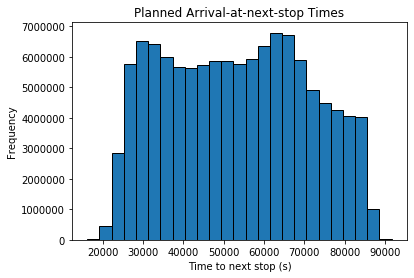

In [100]:
plt.figure()
plt.xlabel('Time to next stop (s)')
plt.title("Planned Arrival-at-next-stop Times")
df.PLANNEDTIME_ARR.plot(kind='hist', bins=25, edgecolor='black')
plt.savefig("Planned Arrival-at-next-stop Times")

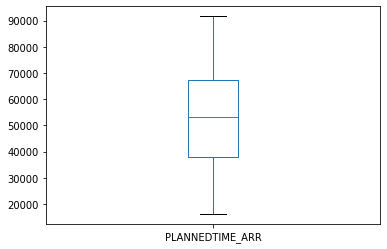

In [88]:
df.PLANNEDTIME_ARR.plot(kind='box')

Actual

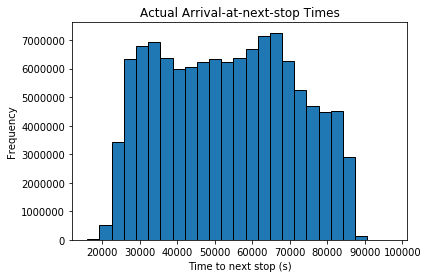

In [101]:
plt.figure()
plt.xlabel('Time to next stop (s)')
plt.title("Actual Arrival-at-next-stop Times")
df.ACTUALTIME_ARR.plot(kind='hist', bins=25, edgecolor='black')
plt.savefig("Actual Arrival-at-next-stop Times")

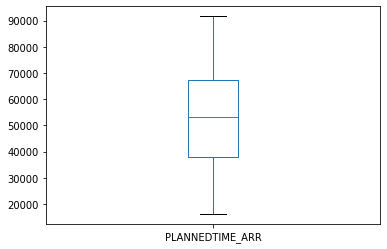

In [88]:
df.PLANNEDTIME_ARR.plot(kind='box')

In [65]:
# show the route for a given bus on Jan1 ordered by sequential
# position of the stops along the route

example_query = df.loc[(df.VEHICLEID == 2693211) & \
                (df.DAYOFSERVICE == pd.to_datetime('1/1/2018', dayfirst=True))]\
                .loc[df.TRIPID == 5972116].sort_values(by='PROGRNUMBER')

example_query

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,LASTUPDATE
2725,2018-01-01,5972116,1,226,47400,47400,47427,47427,2693211,2018-01-08 17:21:10
2754,2018-01-01,5972116,2,228,47451,47451,47461,47461,2693211,2018-01-08 17:21:10
168280,2018-01-01,5972116,3,229,47493,47493,47483,47554,2693211,2018-01-08 17:21:10
2963,2018-01-01,5972116,4,227,47562,47562,47596,47596,2693211,2018-01-08 17:21:10
2993,2018-01-01,5972116,5,230,47604,47604,47620,47620,2693211,2018-01-08 17:21:10
168281,2018-01-01,5972116,6,231,47661,47661,47726,47740,2693211,2018-01-08 17:21:10
3197,2018-01-01,5972116,7,1641,47755,47755,47800,47800,2693211,2018-01-08 17:21:10
3224,2018-01-01,5972116,8,1642,47814,47814,47833,47833,2693211,2018-01-08 17:21:10
168282,2018-01-01,5972116,9,213,47874,47874,47870,47892,2693211,2018-01-08 17:21:10
3430,2018-01-01,5972116,10,214,47924,47924,47915,47915,2693211,2018-01-08 17:21:10


In [103]:
# for documentation

example_query.head().to_csv("time_to_stop.csv")

In [111]:
example_query.loc[:, ['PLANNEDTIME_ARR', 'ACTUALTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_DEP']].head(10)

,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP
2725,47400,47427,47400,47427
2754,47451,47461,47451,47461
168280,47493,47483,47493,47554
2963,47562,47596,47562,47596
2993,47604,47620,47604,47620
168281,47661,47726,47661,47740
3197,47755,47800,47755,47800
3224,47814,47833,47814,47833
168282,47874,47870,47874,47892
3430,47924,47915,47924,47915


<br>

Observations

<br>

- Planned Time of Departure from a stop is always the same as the time of arrive at the stop, i.e. stopping at a stop is not accounted for.

<br>

- The time in seconds is perhaps cumulative from the beginning of the operational day. We cannot tell using this table as no TIME within the DAY OF SERVICE is given.

<br>

- From the smallest / largest values: there is NO value for predicted arrival at next stop under 4.5hrs. Perhaps the operation day is defined as starting at midnight, or – in any case – hours before the start of service.

<br>

### Examining: More Actual Times than Predicted Times

This is likely accounted for by Observation 1, above.

We look for corroboration:

In [91]:
# the percentage of instances of a bus not having stopped at a stop-point along a route

(len(df.loc[df.ACTUALTIME_ARR == df.ACTUALTIME_DEP]) / len(df)) * 100

45.57934697632123

In [92]:
# check that the planned values always do not account for stops

(len(df.loc[df.PLANNEDTIME_ARR == df.PLANNEDTIME_DEP]) / len(df)) * 100

100.0

# READ-IN FEATHER

In [7]:
df = pd.read_feather('/tmp/ssh_mount/rt_leavetimes/020719_postassessquality_leavetimes.feather')

In [8]:
df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID
0,2018-01-01,5972116,12,119,48030,48030,48012,48012,2693211
1,2018-01-01,5966674,12,119,54001,54001,54023,54023,2693267
2,2018-01-01,5959105,12,119,60001,60001,59955,59955,2693263
3,2018-01-01,5966888,12,119,58801,58801,58771,58771,2693284
4,2018-01-01,5965960,12,119,56401,56401,56309,56323,2693209
